# 1. Importing modules and functions

In [4]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from copy import deepcopy
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [5]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [6]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [8]:
# Set file path
df_ws=pd.read_csv('datasets/rat_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382
...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466


##  Standardization  for work set

In [10]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws[df_ws['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1858 molecules


In [11]:
moldf_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
...,...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...


In [12]:
y_tr=moldf_ws.rat_intravenous_LD50	
y_tr

0       0.674442
1       1.023664
2       1.072628
3       1.073618
4       1.123382
          ...   
1853    7.232647
1854    7.270733
1855    7.458497
1856    7.805466
1857    7.842020
Name: rat_intravenous_LD50, Length: 1858, dtype: float64

In [13]:
moldf_ws=moldf_ws.Molecule

##  Load data and curation test set

In [15]:
df_ts=pd.read_csv('datasets/rat_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244
...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383


##  Standardization  for test set

In [17]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  465 molecules


In [18]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458,<rdkit.Chem.rdchem.Mol object at 0x000001D9393...
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
...,...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383,<rdkit.Chem.rdchem.Mol object at 0x000001D9394...


In [19]:
y_ts=moldf_ts.rat_intravenous_LD50
y_ts

0      0.496458
1      1.108409
2      1.182929
3      1.279650
4      1.364244
         ...   
460    6.425276
461    6.555355
462    6.612129
463    7.094383
464    7.582023
Name: rat_intravenous_LD50, Length: 465, dtype: float64

In [20]:
moldf_ts=moldf_ts.Molecule

# Calculation RDKit_2D descriptors for work set

In [22]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [23]:
descr_tr= []
for m in moldf_ws:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [24]:
df_RDKit_2D = pd.DataFrame(x_tr,columns=header)

In [25]:
df_RDKit_2D.head(2)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068,54.028,59.037114,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.444444,9.444444,0.166667,0.166667,0.398237,6.50,58.080,52.032,58.041865,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_RDKit_2D.isna().mean().sort_values(ascending=False)

BCUT2D_MWHI       0.015608
BCUT2D_CHGLO      0.015608
BCUT2D_MWLOW      0.015608
BCUT2D_LOGPHI     0.015608
BCUT2D_LOGPLOW    0.015608
                    ...   
SlogP_VSA7        0.000000
SlogP_VSA8        0.000000
SlogP_VSA9        0.000000
TPSA              0.000000
fr_urea           0.000000
Length: 210, dtype: float64

In [27]:
df_RDKit_2D=df_RDKit_2D.dropna(axis=1)
df_RDKit_2D

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.250000,59.068,54.028,59.037114,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.444444,9.444444,0.166667,0.166667,0.398237,6.500000,58.080,52.032,58.041865,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.131944,10.131944,0.203704,0.203704,0.436836,21.000000,85.106,78.050,85.052764,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.111111,8.111111,0.138889,-0.560185,0.435835,15.000000,76.095,68.031,76.052429,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.156019,9.156019,0.284120,-0.553565,0.436683,53.400000,146.142,136.062,146.057909,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,12.004618,12.004618,0.427397,-2.864924,0.477318,14.133333,273.380,251.204,273.074250,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1854,6.862554,6.862554,0.071293,0.071293,0.213660,20.250000,652.832,604.448,652.350140,252.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1855,12.092947,12.092947,0.442012,-2.875412,0.454473,12.312500,287.407,263.215,287.089900,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1856,11.798367,11.798367,0.454519,-2.863590,0.330731,13.882353,319.474,295.282,319.061971,104.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
x_tr= df_RDKit_2D.to_numpy ()

In [29]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(x_tr)
x_tr = scale.transform(x_tr)


In [30]:
x_tr.shape

(1858, 198)

In [31]:
savetxt('models/RDKiT/x_tr_RDKiT.csv', x_tr, delimiter=',')

# Calculation RDKit_2D descriptors for test set

In [33]:
descr_ts = []
for m in moldf_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [34]:
x_ts.shape

(465, 210)

In [35]:
df_RDKit_2D_ts = pd.DataFrame(x_ts,columns=header)
df_RDKit_2D_ts=df_RDKit_2D_ts.dropna(axis=1)
df_RDKit_2D_ts

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.036911,13.036911,0.037945,-3.719798,0.854964,23.964286,401.484,378.300,401.129694,148.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.263138,8.263138,0.041667,0.041667,0.457138,10.200000,150.174,136.062,150.089209,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.468750,2.468750,1.187500,1.187500,0.426761,57.600000,140.190,128.094,140.106196,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.625000,7.625000,0.125000,-0.125000,0.407528,7.500000,62.068,56.020,62.036779,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.658623,8.658623,0.296528,-0.440972,0.557820,17.333333,134.175,120.063,134.094294,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,15.763058,15.763058,0.015694,-2.322954,0.017465,54.414634,1783.821,1656.813,1782.757112,708.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
461,11.973056,11.973056,0.295525,-3.721836,0.549344,18.625000,140.094,130.014,140.040244,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462,12.503056,12.503056,0.168889,-3.818295,0.612595,20.909091,182.175,166.047,182.087195,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,11.517600,11.517600,0.530498,-2.358735,0.629468,16.416667,211.267,193.123,211.079586,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
x_ts= df_RDKit_2D_ts.to_numpy ()

In [37]:
x_ts = scale.transform(x_ts)

In [42]:
x_ts.shape

(465, 198)

# CatBoostRegressor

In [59]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [61]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 6min 6s
Wall time: 1h 5s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000292478DA930>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [77]:
best_CatBR = grid.best_estimator_

In [78]:
grid.best_params_

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.05}

In [79]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [80]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.99

In [81]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.08

In [72]:
params={'verbose': False}

In [85]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

CPU times: total: 23min 18s
Wall time: 1min 42s


In [86]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.62

In [87]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.61

# save the model to disk

In [109]:
pickle.dump(best_CatBR, open('Models/RDKiT/Toxicity_CatBoost_RDKiT.pkl', 'wb'))

# load the model from disk

In [53]:
best_CatBR = pickle.load(open('Models/RDKiT/Toxicity_CatBoost_RDKiT.pkl', 'rb'))

# Prediction for test set's molecules

In [54]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [55]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [56]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.54

In [57]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.67

# Calculate Feature Importance

In [84]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': df_RDKit_2D.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

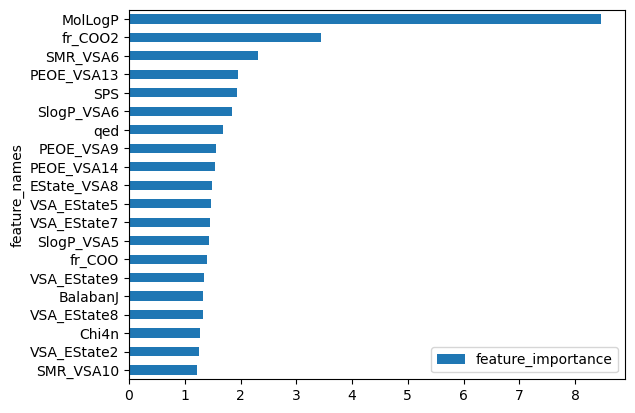

In [87]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

# Y-randomization GradientBoostingRegressor model

In [72]:
params={'verbose': False}

In [74]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_CatBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=42)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

True score =  0.62 
Y-randomization =  -0.15 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [112]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [113]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.278298,5.264513,3.572631,2.228470,5.538348,5.678755,5.712888,4.652989,7.080502,2.134728,...,0.780031,3.471250,10.047299,6.808771,9.839932,1.660956,5.451741,1.660956,3.016921,3.016921
2,5.618798,5.451744,4.212006,2.915604,5.760081,5.712888,5.760081,4.768034,7.098757,3.010456,...,4.957717,10.570370,10.314266,10.407419,9.973913,3.085559,10.131473,4.013405,4.770460,4.748757
3,5.796183,5.696083,4.432254,2.933814,6.520655,6.185570,5.796009,5.020758,7.276223,3.334416,...,11.695935,13.019935,19.250340,11.352737,10.029794,3.816893,10.595569,4.664455,4.920321,4.851285
4,5.933593,5.881301,4.436495,3.031140,6.611052,6.189932,6.198032,5.254032,7.595345,4.301024,...,13.992493,13.176237,19.856151,13.843886,10.352773,4.448953,11.352737,5.124719,5.188201,5.124719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,65.355659,65.025278,64.119624,64.181190,59.809320,61.284263,60.051772,65.124277,62.725384,62.902489,...,56.101397,51.608357,50.705122,55.543079,55.833180,61.029901,55.363034,60.652203,60.188890,60.065286
1854,66.188064,66.823630,65.806257,66.575163,64.880977,64.550274,63.770550,67.406064,63.359095,65.737778,...,59.455129,55.061545,52.580557,57.605415,56.300556,63.378233,57.973211,63.158997,62.438020,61.961763
1855,66.899836,67.129796,66.482026,66.749004,65.085975,65.160285,64.716062,67.818730,64.215814,65.787278,...,60.320003,56.163909,55.724899,57.935930,57.582408,63.496150,59.606779,63.264957,63.305076,62.767074
1856,67.165397,67.869231,66.739141,67.799599,66.076196,65.659146,64.744444,68.937075,65.497594,66.883710,...,62.025350,59.282349,56.863382,59.933904,58.294818,64.622560,60.497194,64.448972,64.636612,64.070134


In [115]:
similarity= neighbors_k

In [116]:
Dmean=np.mean(similarity[1,:])

In [118]:
round(Dmean, 2)

5.58

In [121]:
std=np.std(similarity[1,:])

In [122]:
round(std, 2)

4.07

In [123]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

7.61


In [125]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [126]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,7.612761,3.054436,3.189552,2.851090,2.928271,4.068674,2.342079,6.029682,1.103447,1.310048,...,2.133098,5.785177,1.081373,8.597169,8.474995,2.302304e+09,4.749784,4.690021,4.072557,4.890014
1,8.253038,3.887678,10.249653,3.083254,3.269481,6.929756,4.218637,10.388320,1.391994,2.312527,...,2.680689,6.135874,1.747937,8.669797,8.504462,2.302304e+09,4.919781,5.424674,4.107671,4.895124
2,9.375738,4.090654,10.484625,4.208473,3.436210,8.356529,4.514995,11.056707,1.603521,2.496434,...,3.324423,6.598151,3.252240,8.692325,8.566585,2.302304e+09,5.046468,5.665510,4.125083,5.041647
3,10.005852,4.893968,10.509339,4.586266,3.503441,9.347283,4.810987,11.327389,2.600272,2.541940,...,8.054626,6.733611,4.384348,8.751437,8.654812,2.302304e+09,5.081784,5.670467,4.674199,5.136984
4,11.581464,5.010117,11.576653,4.596129,4.307268,9.944352,4.819812,11.446450,2.632161,2.779297,...,8.331380,7.476514,4.632427,8.838978,8.659986,2.302304e+09,5.093939,5.729482,4.921711,5.701106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,59.311031,61.532010,60.451053,64.012356,62.542117,60.468608,63.842873,61.244701,56.844853,56.158059,...,60.068625,59.392870,60.812038,61.470062,56.913389,2.302304e+09,63.846876,63.212937,62.128424,61.565221
1854,59.392158,64.840484,65.595476,66.485329,65.213559,61.633729,65.464397,63.294165,57.075360,56.466526,...,60.496401,59.503269,63.178196,61.884394,60.092364,2.302304e+09,64.770396,64.165937,64.243916,63.166670
1855,60.787357,64.994210,65.708988,66.767206,65.503475,62.342240,66.194640,63.455762,59.770656,58.897335,...,61.870850,60.625985,63.241020,61.942480,61.157813,2.302304e+09,65.910432,65.142607,64.398966,63.224873
1856,61.235072,65.923019,66.627596,67.922242,66.353394,63.588986,66.408404,64.432974,60.365661,59.292611,...,62.247938,61.579547,64.356864,62.655501,61.562391,2.302304e+09,66.918598,66.111548,65.500880,64.237838


In [127]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[7.61300000e+00 3.05400000e+00 3.19000000e+00 2.85100000e+00
 2.92800000e+00 4.06900000e+00 2.34200000e+00 6.03000000e+00
 1.10300000e+00 1.31000000e+00 2.31000000e+00 6.94800000e+00
 1.62200000e+00 4.22900000e+00 3.37000000e+00 3.20000000e+00
 8.96300000e+00 7.10300000e+00 9.65100000e+00 4.03700000e+00
 5.19900000e+00 1.31780000e+01 1.03400000e+01 1.34510000e+01
 1.09540000e+01 4.12500000e+00 6.40600000e+00 7.20900000e+00
 1.55500000e+00 3.11000000e+00 3.18600000e+00 4.37400000e+00
 1.20190000e+01 7.23700000e+00 1.18530000e+01 7.41200000e+00
 5.97700000e+00 7.49600000e+00 6.32700000e+00 4.26100000e+00
 1.34570000e+01 1.77700000e+00 5.70300000e+00 3.55100000e+00
 1.60090000e+01 6.47100000e+00 1.11260000e+01 2.89500000e+00
 1.83720000e+01 2.33400000e+00 5.43500000e+00 3.36300000e+00
 2.42000000e+00 1.81470000e+01 1.53000000e+00 5.11000000e+00
 7.62000000e+00 1.10320000e+01 6.36600000e+00 5.56700000e+00
 7.41700000e+00 1.92800000e+00 6.77900000e+00 1.02990000e+01
 1.10500000e+00 7.527000

In [128]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True False False False
 False  True  True  True  True  True  True  True False  True False  True
  True  True  True  True False  True  True  True False  True False  True
 False  True  True  True  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True False
  True False False  True  True False  True  True  True  True  True  True
  True False  True False  True  True  True  True False  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False  True False  True  True  True False False  True
  True  True  True  True  True False  True  True  True  True False  True
 False False  True  True  True  True  True  True Fa

In [131]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.79


In [134]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  19  20
  25  26  27  28  29  30  31  33  35  36  37  38  39  41  42  43  45  47
  49  50  51  52  54  55  58  59  60  61  62  64  65  66  67  69  70  72
  75  76  78  79  80  81  82  83  84  86  88  89  90  91  93  94  95  96
  97 100 101 102 103 105 106 107 108 109 110 111 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 131 133 134 136 138 139 140 143
 144 145 146 147 148 150 151 152 153 155 158 159 160 161 162 163 166 167
 168 169 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 187
 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 206
 207 210 211 212 213 216 217 219 220 222 224 225 226 227 229 230 231 233
 234 237 238 241 242 243 244 245 246 247 248 249 250 251 253 255 256 257
 258 259 260 261 262 263 264 266 267 268 269 270 272 273 275 276 278 279
 280 281 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 30

In [138]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [141]:
y_pred_GBR_ad=list(y_pred_GBR)

In [143]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [144]:
len(y_pred_GBR_ad)

366

In [146]:
y_ts_ad=list(y_ts)

In [147]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [148]:
len(y_ts_ad)

366

In [149]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.66

In [150]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.56

# SVM model building and validation

In [162]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [164]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [165]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [166]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [167]:
svm.best_params_
best_svm = svm.best_estimator_

In [170]:
svm.best_params_

{'C': 1, 'gamma': 0.01}

In [171]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [172]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.82

In [173]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.42

In [174]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [175]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.57

In [176]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.64

# Prediction for test set's molecules

In [69]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [71]:
y_pred_svm = best_svm.predict(x_ts)

In [73]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.5

In [75]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.7

save the model to disk

In [183]:
pickle.dump(best_svm, open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'wb'))

load the model from disk

In [67]:
best_svm = pickle.load(open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [78]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [80]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.278298,5.264513,3.572631,2.228470,5.538348,5.678755,5.712888,4.652989,7.080502,2.134728,...,0.780031,3.471250,10.047299,6.808771,9.839932,1.660956,5.451741,1.660956,3.016921,3.016921
2,5.618798,5.451744,4.212006,2.915604,5.760081,5.712888,5.760081,4.768034,7.098757,3.010456,...,4.957717,10.570370,10.314266,10.407419,9.973913,3.085559,10.131473,4.013405,4.770460,4.748757
3,5.796183,5.696083,4.432254,2.933814,6.520655,6.185570,5.796009,5.020758,7.276223,3.334416,...,11.695935,13.019935,19.250340,11.352737,10.029794,3.816893,10.595569,4.664455,4.920321,4.851285
4,5.933593,5.881301,4.436495,3.031140,6.611052,6.189932,6.198032,5.254032,7.595345,4.301024,...,13.992493,13.176237,19.856151,13.843886,10.352773,4.448953,11.352737,5.124719,5.188201,5.124719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,65.355659,65.025278,64.119624,64.181190,59.809320,61.284263,60.051772,65.124277,62.725384,62.902489,...,56.101397,51.608357,50.705122,55.543079,55.833180,61.029901,55.363034,60.652203,60.188890,60.065286
1854,66.188064,66.823630,65.806257,66.575163,64.880977,64.550274,63.770550,67.406064,63.359095,65.737778,...,59.455129,55.061545,52.580557,57.605415,56.300556,63.378233,57.973211,63.158997,62.438020,61.961763
1855,66.899836,67.129796,66.482026,66.749004,65.085975,65.160285,64.716062,67.818730,64.215814,65.787278,...,60.320003,56.163909,55.724899,57.935930,57.582408,63.496150,59.606779,63.264957,63.305076,62.767074
1856,67.165397,67.869231,66.739141,67.799599,66.076196,65.659146,64.744444,68.937075,65.497594,66.883710,...,62.025350,59.282349,56.863382,59.933904,58.294818,64.622560,60.497194,64.448972,64.636612,64.070134


In [81]:
similarity= neighbors_k

In [82]:
Dmean=np.mean(similarity[1,:])

In [85]:
round(Dmean, 2)

5.58

In [86]:
std=np.std(similarity[1,:])

In [88]:
round(std, 2)

4.07

In [89]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

7.61


In [90]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [91]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,7.612761,3.054436,3.189552,2.851090,2.928271,4.068674,2.342079,6.029682,1.103447,1.310048,...,2.133098,5.785177,1.081373,8.597169,8.474995,2.302304e+09,4.749784,4.690021,4.072557,4.890014
1,8.253038,3.887678,10.249653,3.083254,3.269481,6.929756,4.218637,10.388320,1.391994,2.312527,...,2.680689,6.135874,1.747937,8.669797,8.504462,2.302304e+09,4.919781,5.424674,4.107671,4.895124
2,9.375738,4.090654,10.484625,4.208473,3.436210,8.356529,4.514995,11.056707,1.603521,2.496434,...,3.324423,6.598151,3.252240,8.692325,8.566585,2.302304e+09,5.046468,5.665510,4.125083,5.041647
3,10.005852,4.893968,10.509339,4.586266,3.503441,9.347283,4.810987,11.327389,2.600272,2.541940,...,8.054626,6.733611,4.384348,8.751437,8.654812,2.302304e+09,5.081784,5.670467,4.674199,5.136984
4,11.581464,5.010117,11.576653,4.596129,4.307268,9.944352,4.819812,11.446450,2.632161,2.779297,...,8.331380,7.476514,4.632427,8.838978,8.659986,2.302304e+09,5.093939,5.729482,4.921711,5.701106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,59.311031,61.532010,60.451053,64.012356,62.542117,60.468608,63.842873,61.244701,56.844853,56.158059,...,60.068625,59.392870,60.812038,61.470062,56.913389,2.302304e+09,63.846876,63.212937,62.128424,61.565221
1854,59.392158,64.840484,65.595476,66.485329,65.213559,61.633729,65.464397,63.294165,57.075360,56.466526,...,60.496401,59.503269,63.178196,61.884394,60.092364,2.302304e+09,64.770396,64.165937,64.243916,63.166670
1855,60.787357,64.994210,65.708988,66.767206,65.503475,62.342240,66.194640,63.455762,59.770656,58.897335,...,61.870850,60.625985,63.241020,61.942480,61.157813,2.302304e+09,65.910432,65.142607,64.398966,63.224873
1856,61.235072,65.923019,66.627596,67.922242,66.353394,63.588986,66.408404,64.432974,60.365661,59.292611,...,62.247938,61.579547,64.356864,62.655501,61.562391,2.302304e+09,66.918598,66.111548,65.500880,64.237838


In [92]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[7.61300000e+00 3.05400000e+00 3.19000000e+00 2.85100000e+00
 2.92800000e+00 4.06900000e+00 2.34200000e+00 6.03000000e+00
 1.10300000e+00 1.31000000e+00 2.31000000e+00 6.94800000e+00
 1.62200000e+00 4.22900000e+00 3.37000000e+00 3.20000000e+00
 8.96300000e+00 7.10300000e+00 9.65100000e+00 4.03700000e+00
 5.19900000e+00 1.31780000e+01 1.03400000e+01 1.34510000e+01
 1.09540000e+01 4.12500000e+00 6.40600000e+00 7.20900000e+00
 1.55500000e+00 3.11000000e+00 3.18600000e+00 4.37400000e+00
 1.20190000e+01 7.23700000e+00 1.18530000e+01 7.41200000e+00
 5.97700000e+00 7.49600000e+00 6.32700000e+00 4.26100000e+00
 1.34570000e+01 1.77700000e+00 5.70300000e+00 3.55100000e+00
 1.60090000e+01 6.47100000e+00 1.11260000e+01 2.89500000e+00
 1.83720000e+01 2.33400000e+00 5.43500000e+00 3.36300000e+00
 2.42000000e+00 1.81470000e+01 1.53000000e+00 5.11000000e+00
 7.62000000e+00 1.10320000e+01 6.36600000e+00 5.56700000e+00
 7.41700000e+00 1.92800000e+00 6.77900000e+00 1.02990000e+01
 1.10500000e+00 7.527000

In [93]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True False False False
 False  True  True  True  True  True  True  True False  True False  True
  True  True  True  True False  True  True  True False  True False  True
 False  True  True  True  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True False
  True False False  True  True False  True  True  True  True  True  True
  True False  True False  True  True  True  True False  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False  True False  True  True  True False False  True
  True  True  True  True  True False  True  True  True  True False  True
 False False  True  True  True  True  True  True Fa

In [94]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.79


In [95]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  19  20
  25  26  27  28  29  30  31  33  35  36  37  38  39  41  42  43  45  47
  49  50  51  52  54  55  58  59  60  61  62  64  65  66  67  69  70  72
  75  76  78  79  80  81  82  83  84  86  88  89  90  91  93  94  95  96
  97 100 101 102 103 105 106 107 108 109 110 111 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 131 133 134 136 138 139 140 143
 144 145 146 147 148 150 151 152 153 155 158 159 160 161 162 163 166 167
 168 169 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 187
 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 206
 207 210 211 212 213 216 217 219 220 222 224 225 226 227 229 230 231 233
 234 237 238 241 242 243 244 245 246 247 248 249 250 251 253 255 256 257
 258 259 260 261 262 263 264 266 267 268 269 270 272 273 275 276 278 279
 280 281 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 30

In [98]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [102]:
y_pred_svm_ad=list(y_pred_svm)

In [106]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [113]:
len(y_pred_svm_ad)

366

In [114]:
y_ts_ad=list(y_ts)

In [115]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [116]:
len(y_ts_ad)

366

In [117]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.61

In [118]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.6

# Multi-layer Perceptron regressor

In [135]:
from sklearn.neural_network import MLPRegressor

In [137]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [139]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [140]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [143]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [144]:
best_MLPR = m.best_estimator_

In [145]:
m.best_params_

{'activation': 'tanh',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 1000,
 'solver': 'adam'}

In [146]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [147]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.98

In [148]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.12

In [149]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [150]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.47

In [151]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.72

# Prediction for test set's molecules

In [153]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [154]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [155]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.39

In [156]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.77

# save the model to disk

In [171]:
pickle.dump(best_MLPR, open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'wb'))

# load the model from disk

In [125]:
best_MLPR = pickle.load(open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [174]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [175]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.278298,5.264513,3.572631,2.228470,5.538348,5.678755,5.712888,4.652989,7.080502,2.134728,...,0.780031,3.471250,10.047299,6.808771,9.839932,1.660956,5.451741,1.660956,3.016921,3.016921
2,5.618798,5.451744,4.212006,2.915604,5.760081,5.712888,5.760081,4.768034,7.098757,3.010456,...,4.957717,10.570370,10.314266,10.407419,9.973913,3.085559,10.131473,4.013405,4.770460,4.748757
3,5.796183,5.696083,4.432254,2.933814,6.520655,6.185570,5.796009,5.020758,7.276223,3.334416,...,11.695935,13.019935,19.250340,11.352737,10.029794,3.816893,10.595569,4.664455,4.920321,4.851285
4,5.933593,5.881301,4.436495,3.031140,6.611052,6.189932,6.198032,5.254032,7.595345,4.301024,...,13.992493,13.176237,19.856151,13.843886,10.352773,4.448953,11.352737,5.124719,5.188201,5.124719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,65.355659,65.025278,64.119624,64.181190,59.809320,61.284263,60.051772,65.124277,62.725384,62.902489,...,56.101397,51.608357,50.705122,55.543079,55.833180,61.029901,55.363034,60.652203,60.188890,60.065286
1854,66.188064,66.823630,65.806257,66.575163,64.880977,64.550274,63.770550,67.406064,63.359095,65.737778,...,59.455129,55.061545,52.580557,57.605415,56.300556,63.378233,57.973211,63.158997,62.438020,61.961763
1855,66.899836,67.129796,66.482026,66.749004,65.085975,65.160285,64.716062,67.818730,64.215814,65.787278,...,60.320003,56.163909,55.724899,57.935930,57.582408,63.496150,59.606779,63.264957,63.305076,62.767074
1856,67.165397,67.869231,66.739141,67.799599,66.076196,65.659146,64.744444,68.937075,65.497594,66.883710,...,62.025350,59.282349,56.863382,59.933904,58.294818,64.622560,60.497194,64.448972,64.636612,64.070134


In [176]:
similarity= neighbors_k

In [179]:
Dmean=np.mean(similarity[1,:])

In [180]:
round(Dmean, 2)

5.58

In [182]:
std=np.std(similarity[1,:])

In [183]:
round(std, 2)

4.07

In [184]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

7.61


In [187]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [188]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,7.612761,3.054436,3.189552,2.851090,2.928271,4.068674,2.342079,6.029682,1.103447,1.310048,...,2.133098,5.785177,1.081373,8.597169,8.474995,2.302304e+09,4.749784,4.690021,4.072557,4.890014
1,8.253038,3.887678,10.249653,3.083254,3.269481,6.929756,4.218637,10.388320,1.391994,2.312527,...,2.680689,6.135874,1.747937,8.669797,8.504462,2.302304e+09,4.919781,5.424674,4.107671,4.895124
2,9.375738,4.090654,10.484625,4.208473,3.436210,8.356529,4.514995,11.056707,1.603521,2.496434,...,3.324423,6.598151,3.252240,8.692325,8.566585,2.302304e+09,5.046468,5.665510,4.125083,5.041647
3,10.005852,4.893968,10.509339,4.586266,3.503441,9.347283,4.810987,11.327389,2.600272,2.541940,...,8.054626,6.733611,4.384348,8.751437,8.654812,2.302304e+09,5.081784,5.670467,4.674199,5.136984
4,11.581464,5.010117,11.576653,4.596129,4.307268,9.944352,4.819812,11.446450,2.632161,2.779297,...,8.331380,7.476514,4.632427,8.838978,8.659986,2.302304e+09,5.093939,5.729482,4.921711,5.701106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,59.311031,61.532010,60.451053,64.012356,62.542117,60.468608,63.842873,61.244701,56.844853,56.158059,...,60.068625,59.392870,60.812038,61.470062,56.913389,2.302304e+09,63.846876,63.212937,62.128424,61.565221
1854,59.392158,64.840484,65.595476,66.485329,65.213559,61.633729,65.464397,63.294165,57.075360,56.466526,...,60.496401,59.503269,63.178196,61.884394,60.092364,2.302304e+09,64.770396,64.165937,64.243916,63.166670
1855,60.787357,64.994210,65.708988,66.767206,65.503475,62.342240,66.194640,63.455762,59.770656,58.897335,...,61.870850,60.625985,63.241020,61.942480,61.157813,2.302304e+09,65.910432,65.142607,64.398966,63.224873
1856,61.235072,65.923019,66.627596,67.922242,66.353394,63.588986,66.408404,64.432974,60.365661,59.292611,...,62.247938,61.579547,64.356864,62.655501,61.562391,2.302304e+09,66.918598,66.111548,65.500880,64.237838


In [189]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[7.61300000e+00 3.05400000e+00 3.19000000e+00 2.85100000e+00
 2.92800000e+00 4.06900000e+00 2.34200000e+00 6.03000000e+00
 1.10300000e+00 1.31000000e+00 2.31000000e+00 6.94800000e+00
 1.62200000e+00 4.22900000e+00 3.37000000e+00 3.20000000e+00
 8.96300000e+00 7.10300000e+00 9.65100000e+00 4.03700000e+00
 5.19900000e+00 1.31780000e+01 1.03400000e+01 1.34510000e+01
 1.09540000e+01 4.12500000e+00 6.40600000e+00 7.20900000e+00
 1.55500000e+00 3.11000000e+00 3.18600000e+00 4.37400000e+00
 1.20190000e+01 7.23700000e+00 1.18530000e+01 7.41200000e+00
 5.97700000e+00 7.49600000e+00 6.32700000e+00 4.26100000e+00
 1.34570000e+01 1.77700000e+00 5.70300000e+00 3.55100000e+00
 1.60090000e+01 6.47100000e+00 1.11260000e+01 2.89500000e+00
 1.83720000e+01 2.33400000e+00 5.43500000e+00 3.36300000e+00
 2.42000000e+00 1.81470000e+01 1.53000000e+00 5.11000000e+00
 7.62000000e+00 1.10320000e+01 6.36600000e+00 5.56700000e+00
 7.41700000e+00 1.92800000e+00 6.77900000e+00 1.02990000e+01
 1.10500000e+00 7.527000

In [193]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True False False False
 False  True  True  True  True  True  True  True False  True False  True
  True  True  True  True False  True  True  True False  True False  True
 False  True  True  True  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True False
  True False False  True  True False  True  True  True  True  True  True
  True False  True False  True  True  True  True False  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False  True False  True  True  True False False  True
  True  True  True  True  True False  True  True  True  True False  True
 False False  True  True  True  True  True  True Fa

In [194]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.79


In [195]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  19  20
  25  26  27  28  29  30  31  33  35  36  37  38  39  41  42  43  45  47
  49  50  51  52  54  55  58  59  60  61  62  64  65  66  67  69  70  72
  75  76  78  79  80  81  82  83  84  86  88  89  90  91  93  94  95  96
  97 100 101 102 103 105 106 107 108 109 110 111 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 131 133 134 136 138 139 140 143
 144 145 146 147 148 150 151 152 153 155 158 159 160 161 162 163 166 167
 168 169 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 187
 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 206
 207 210 211 212 213 216 217 219 220 222 224 225 226 227 229 230 231 233
 234 237 238 241 242 243 244 245 246 247 248 249 250 251 253 255 256 257
 258 259 260 261 262 263 264 266 267 268 269 270 272 273 275 276 278 279
 280 281 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 30

In [196]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [288]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [289]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [290]:
len(y_pred_MLPR_ad)

366

In [291]:
y_ts_ad=list(y_ts)

In [292]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [293]:
len(y_ts_ad)

366

In [294]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.55

In [295]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.65

# k-nearest neighbors

In [297]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [298]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [299]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [300]:
best_kNN = m.best_estimator_

In [301]:
m.best_params_

{'n_neighbors': 9}

In [302]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [303]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.63

In [304]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.6

In [305]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [306]:
y_pred_CV_kNN

array([1.89161626, 1.74762144, 2.18536199, ..., 5.07070682, 5.40717023,
       5.38352944])

In [307]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.51

In [308]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.69

# Prediction for test set's molecules

In [310]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [311]:
y_pred_kNN = best_kNN.predict(x_ts)

In [312]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.44

In [313]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.74

# save the model to disk

In [315]:
pickle.dump(best_kNN, open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'wb'))

# load the model from disk

In [203]:
best_kNN = pickle.load(open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [317]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [318]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.278298,5.264513,3.572631,2.228470,5.538348,5.678755,5.712888,4.652989,7.080502,2.134728,...,0.780031,3.471250,10.047299,6.808771,9.839932,1.660956,5.451741,1.660956,3.016921,3.016921
2,5.618798,5.451744,4.212006,2.915604,5.760081,5.712888,5.760081,4.768034,7.098757,3.010456,...,4.957717,10.570370,10.314266,10.407419,9.973913,3.085559,10.131473,4.013405,4.770460,4.748757
3,5.796183,5.696083,4.432254,2.933814,6.520655,6.185570,5.796009,5.020758,7.276223,3.334416,...,11.695935,13.019935,19.250340,11.352737,10.029794,3.816893,10.595569,4.664455,4.920321,4.851285
4,5.933593,5.881301,4.436495,3.031140,6.611052,6.189932,6.198032,5.254032,7.595345,4.301024,...,13.992493,13.176237,19.856151,13.843886,10.352773,4.448953,11.352737,5.124719,5.188201,5.124719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,65.355659,65.025278,64.119624,64.181190,59.809320,61.284263,60.051772,65.124277,62.725384,62.902489,...,56.101397,51.608357,50.705122,55.543079,55.833180,61.029901,55.363034,60.652203,60.188890,60.065286
1854,66.188064,66.823630,65.806257,66.575163,64.880977,64.550274,63.770550,67.406064,63.359095,65.737778,...,59.455129,55.061545,52.580557,57.605415,56.300556,63.378233,57.973211,63.158997,62.438020,61.961763
1855,66.899836,67.129796,66.482026,66.749004,65.085975,65.160285,64.716062,67.818730,64.215814,65.787278,...,60.320003,56.163909,55.724899,57.935930,57.582408,63.496150,59.606779,63.264957,63.305076,62.767074
1856,67.165397,67.869231,66.739141,67.799599,66.076196,65.659146,64.744444,68.937075,65.497594,66.883710,...,62.025350,59.282349,56.863382,59.933904,58.294818,64.622560,60.497194,64.448972,64.636612,64.070134


In [319]:
similarity= neighbors_k

In [320]:
Dmean=np.mean(similarity[1,:])

In [321]:
round(Dmean, 2)

5.58

In [322]:
std=np.std(similarity[1,:])

In [323]:
round(std, 2)

4.07

In [324]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

7.61


In [325]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [326]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,7.612761,3.054436,3.189552,2.851090,2.928271,4.068674,2.342079,6.029682,1.103447,1.310048,...,2.133098,5.785177,1.081373,8.597169,8.474995,2.302304e+09,4.749784,4.690021,4.072557,4.890014
1,8.253038,3.887678,10.249653,3.083254,3.269481,6.929756,4.218637,10.388320,1.391994,2.312527,...,2.680689,6.135874,1.747937,8.669797,8.504462,2.302304e+09,4.919781,5.424674,4.107671,4.895124
2,9.375738,4.090654,10.484625,4.208473,3.436210,8.356529,4.514995,11.056707,1.603521,2.496434,...,3.324423,6.598151,3.252240,8.692325,8.566585,2.302304e+09,5.046468,5.665510,4.125083,5.041647
3,10.005852,4.893968,10.509339,4.586266,3.503441,9.347283,4.810987,11.327389,2.600272,2.541940,...,8.054626,6.733611,4.384348,8.751437,8.654812,2.302304e+09,5.081784,5.670467,4.674199,5.136984
4,11.581464,5.010117,11.576653,4.596129,4.307268,9.944352,4.819812,11.446450,2.632161,2.779297,...,8.331380,7.476514,4.632427,8.838978,8.659986,2.302304e+09,5.093939,5.729482,4.921711,5.701106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,59.311031,61.532010,60.451053,64.012356,62.542117,60.468608,63.842873,61.244701,56.844853,56.158059,...,60.068625,59.392870,60.812038,61.470062,56.913389,2.302304e+09,63.846876,63.212937,62.128424,61.565221
1854,59.392158,64.840484,65.595476,66.485329,65.213559,61.633729,65.464397,63.294165,57.075360,56.466526,...,60.496401,59.503269,63.178196,61.884394,60.092364,2.302304e+09,64.770396,64.165937,64.243916,63.166670
1855,60.787357,64.994210,65.708988,66.767206,65.503475,62.342240,66.194640,63.455762,59.770656,58.897335,...,61.870850,60.625985,63.241020,61.942480,61.157813,2.302304e+09,65.910432,65.142607,64.398966,63.224873
1856,61.235072,65.923019,66.627596,67.922242,66.353394,63.588986,66.408404,64.432974,60.365661,59.292611,...,62.247938,61.579547,64.356864,62.655501,61.562391,2.302304e+09,66.918598,66.111548,65.500880,64.237838


In [327]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[7.61300000e+00 3.05400000e+00 3.19000000e+00 2.85100000e+00
 2.92800000e+00 4.06900000e+00 2.34200000e+00 6.03000000e+00
 1.10300000e+00 1.31000000e+00 2.31000000e+00 6.94800000e+00
 1.62200000e+00 4.22900000e+00 3.37000000e+00 3.20000000e+00
 8.96300000e+00 7.10300000e+00 9.65100000e+00 4.03700000e+00
 5.19900000e+00 1.31780000e+01 1.03400000e+01 1.34510000e+01
 1.09540000e+01 4.12500000e+00 6.40600000e+00 7.20900000e+00
 1.55500000e+00 3.11000000e+00 3.18600000e+00 4.37400000e+00
 1.20190000e+01 7.23700000e+00 1.18530000e+01 7.41200000e+00
 5.97700000e+00 7.49600000e+00 6.32700000e+00 4.26100000e+00
 1.34570000e+01 1.77700000e+00 5.70300000e+00 3.55100000e+00
 1.60090000e+01 6.47100000e+00 1.11260000e+01 2.89500000e+00
 1.83720000e+01 2.33400000e+00 5.43500000e+00 3.36300000e+00
 2.42000000e+00 1.81470000e+01 1.53000000e+00 5.11000000e+00
 7.62000000e+00 1.10320000e+01 6.36600000e+00 5.56700000e+00
 7.41700000e+00 1.92800000e+00 6.77900000e+00 1.02990000e+01
 1.10500000e+00 7.527000

In [328]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True False False False
 False  True  True  True  True  True  True  True False  True False  True
  True  True  True  True False  True  True  True False  True False  True
 False  True  True  True  True False  True  True False False  True  True
  True  True  True False  True  True  True  True False  True  True False
  True False False  True  True False  True  True  True  True  True  True
  True False  True False  True  True  True  True False  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False  True False  True  True  True False False  True
  True  True  True  True  True False  True  True  True  True False  True
 False False  True  True  True  True  True  True Fa

In [329]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.79


In [330]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  19  20
  25  26  27  28  29  30  31  33  35  36  37  38  39  41  42  43  45  47
  49  50  51  52  54  55  58  59  60  61  62  64  65  66  67  69  70  72
  75  76  78  79  80  81  82  83  84  86  88  89  90  91  93  94  95  96
  97 100 101 102 103 105 106 107 108 109 110 111 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 131 133 134 136 138 139 140 143
 144 145 146 147 148 150 151 152 153 155 158 159 160 161 162 163 166 167
 168 169 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 187
 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 206
 207 210 211 212 213 216 217 219 220 222 224 225 226 227 229 230 231 233
 234 237 238 241 242 243 244 245 246 247 248 249 250 251 253 255 256 257
 258 259 260 261 262 263 264 266 267 268 269 270 272 273 275 276 278 279
 280 281 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 30

In [331]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [333]:
y_pred_kNN_ad=list(y_pred_kNN)

In [334]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [335]:
len(y_pred_kNN_ad)

366

In [336]:
y_ts_ad=list(y_ts)

In [337]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [338]:
len(y_ts_ad)

366

In [339]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.52

In [340]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.67

# Analyzing the importance of descriptors for the GBM model

In [77]:
import shap

In [87]:
explainer = shap.Explainer(best_CatBR)

In [88]:
shap_values = explainer(x_tr)

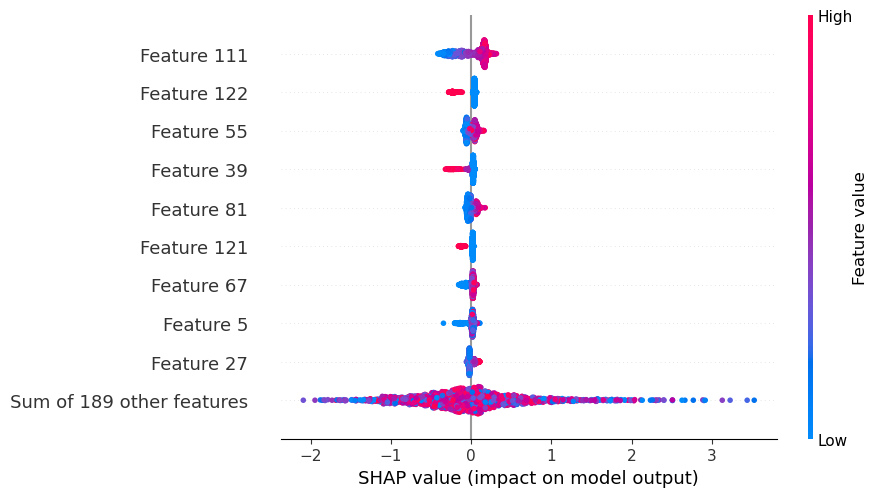

In [89]:
shap.plots.beeswarm(shap_values)

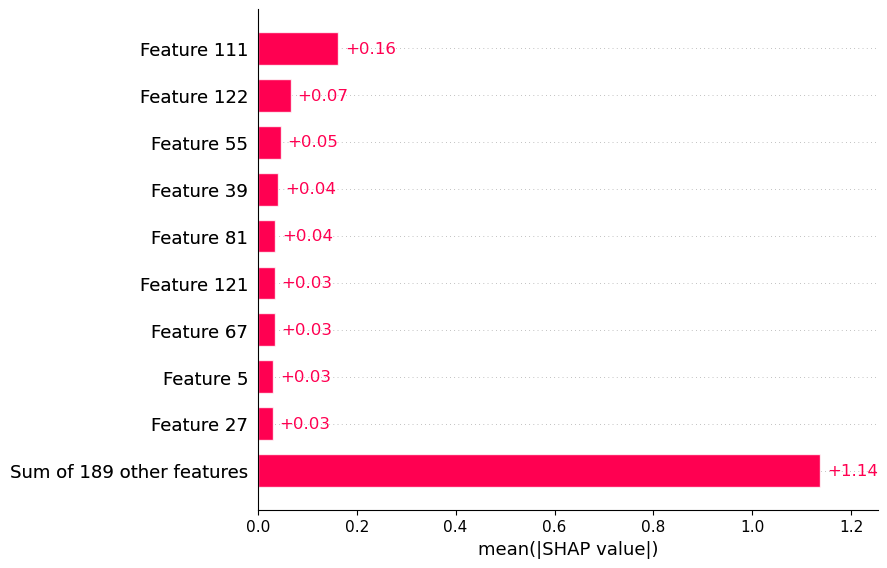

In [93]:
shap.plots.bar(shap_values)